In [1]:
#This command is just used to navigate to the directory were my files are located, please ignore it and navigate to your local directory instead
from os import chdir as cd
cd ('/content/drive/MyDrive/MML/Final_Version')

In [2]:
#libraries to be used
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import os 
import sys
from sklearn.metrics import auc
from collections import OrderedDict
import math
#the following are just for visualization purposes
orange_black = ['#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820']
plt.style.use('ggplot')

In [3]:
#I will also import some functions for visualizations 
from Visualization import create_result_df, plot_results

In [99]:
#importing algorithms to be used
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

Load both Training and testing Folders, in this project I will not use the testing folder, it has no labels and need to be tested on kaggle's platform and due to the purpose of this project I will only study the training set and partition it into three seperate folders and train, test, and then validate. By that I can tune my hyper parameters and not overfit my data on the training set and neither fit my hyper parameters on the testing set

In [5]:
df_train = pd.read_csv('training.csv').set_index('EventId')
df_test = pd.read_csv('test.csv').set_index('EventId')

In [6]:
df_train.shape, df_test.shape

((250000, 32), (550000, 30))

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 100000 to 349999
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 250000 non-null  float64
 1   DER_mass_transverse_met_lep  250000 non-null  float64
 2   DER_mass_vis                 250000 non-null  float64
 3   DER_pt_h                     250000 non-null  float64
 4   DER_deltaeta_jet_jet         250000 non-null  float64
 5   DER_mass_jet_jet             250000 non-null  float64
 6   DER_prodeta_jet_jet          250000 non-null  float64
 7   DER_deltar_tau_lep           250000 non-null  float64
 8   DER_pt_tot                   250000 non-null  float64
 9   DER_sum_pt                   250000 non-null  float64
 10  DER_pt_ratio_lep_tau         250000 non-null  float64
 11  DER_met_phi_centrality       250000 non-null  float64
 12  DER_lep_eta_centrality       250000 non-null  float64

In [8]:
df_train.columns

Index(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [9]:
df_train.describe()

DER_mass_MMC  ...         Weight
count  250000.000000  ...  250000.000000
mean      -49.023079  ...       1.646767
std       406.345647  ...       1.875103
min      -999.000000  ...       0.001502
25%        78.100750  ...       0.018636
50%       105.012000  ...       1.156188
75%       130.606250  ...       2.404128
max      1192.026000  ...       7.822543

[8 rows x 31 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


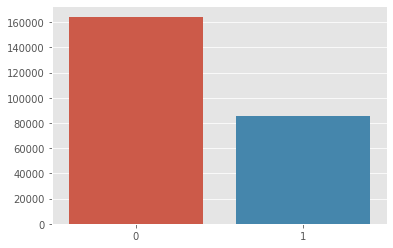

In [10]:
sns.barplot([1,0],[(df_train.iloc[:,-1]=='s').sum(),(df_train.iloc[:,-1]=='b').sum()])
plt.savefig('Balance.png')

As we can see that label 1, which represents 'b' (background), has much higher instances approximately double the ones of 0, that represent 's' (signal), and this might create a bias toward the background and for that we should keep in mind that we need algorithms that are robust for that.

Now we will run a testing model on the data and make some visualization to see how will the model work before processing the data.


Good practice is to always start with the simplest model that could possibly work. For classification, we generally like to begin with logistic regression, as it's extremely common and useful. However, on a first examination of the features, few of them are monotonic in the ratio of signal to background, and therefore the core assumption of logistic regression (that the log odds are linear in the features) appears to be violated.

We could do some simple feature transformations to recover this assumption, but we'll here just switch to another simple model that can handle these feature distributions: Naive Bayes.

# **Naive Bayes**

First I will divide data into three samples of sizes: 175000, 7500, 13500 and then run the classifier without ane preprocessing and make some visualizations.

In [11]:
training = df_train.iloc[0:175000,:]
evaluation = df_train.iloc[175000:182500,:]
holdout = df_train.iloc[182500:,:]
training.shape, evaluation.shape, holdout.shape

((175000, 32), (7500, 32), (67500, 32))

In [12]:
#mapping categorical labels to floats, note that I did not filled the Label column, but I created a new column and kept the previous one
for df in training, evaluation, holdout:
    df.loc[:,'target'] = df.Label.map(lambda l: 1.0 if l=='s' else 0.0)
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [13]:
training.head().loc[:,['target','Label']]

target Label
EventId              
100000      1.0     s
100001      0.0     b
100002      0.0     b
100003      0.0     b
100004      0.0     b

s has 1.0 as image and b has 0.0 as image

In [14]:
naive_bayes = GaussianNB()
naive_bayes.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(naive_bayes.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


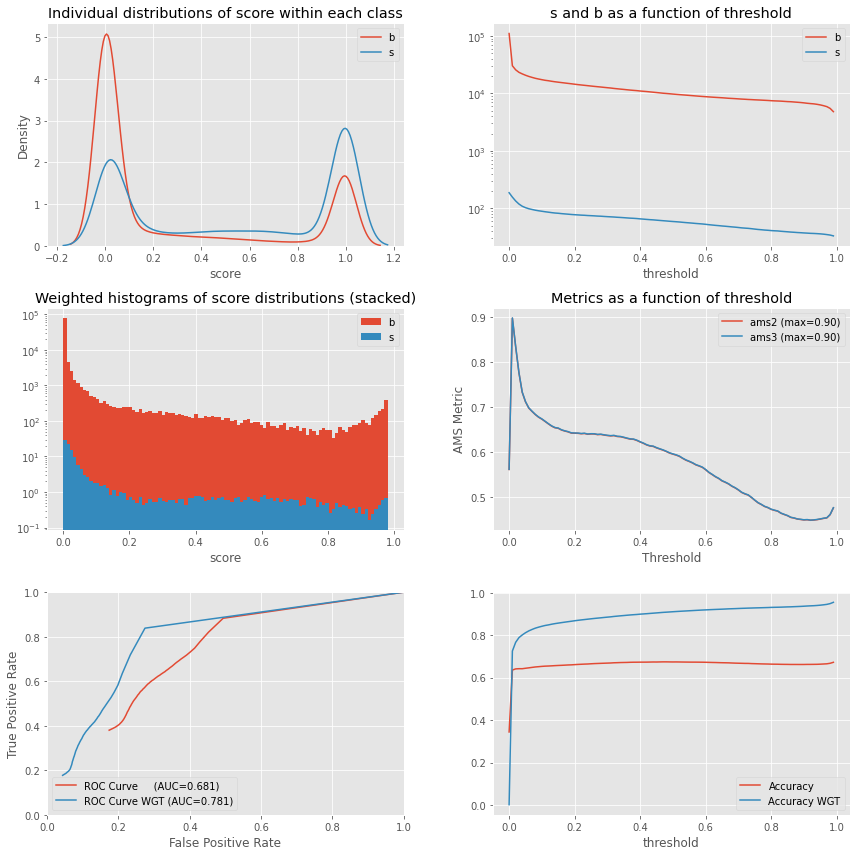

In [15]:
plot_results(nb_score_data, nb_score_summary)
#plt.savefig('NaiveBayes_no processing.png')

Now I will try to deal with Outliers that are filled with -999. After investigating I found that those outliers are not missing data but they can't be calculated due to some physical reasons. They don't exist physically. I will try first to study the distribution of data and choose a value that is far away from the mean by more than 5*std, then I will try filling them with the mean and then I will use machine learning methods to predict them. I will run Naive Bayes after and see the behavior after that and evaluate after some visualizations

In [16]:
cols_der = [col for col in training.columns if col.startswith('DER')]
cols_pri = [col for col in training.columns if col.startswith('PRI')]

#print(len(cols_der), len(cols_pri))

# plot only DER columns
training[cols_der].plot(kind='box', figsize=(16, 8))
plt.xticks(rotation=45);
plt.title('DER_xxx columns')
plt.show()

# plot only PRI columns
training[cols_pri].plot(kind='box', figsize=(16, 8))
plt.xticks(rotation=45);
plt.title('RPI_xxx columns')
plt.show()

In [17]:
(training == -999).sum()  #checking the missing values

DER_mass_MMC                    26771
DER_mass_transverse_met_lep         0
DER_mass_vis                        0
DER_pt_h                            0
DER_deltaeta_jet_jet           124215
DER_mass_jet_jet               124215
DER_prodeta_jet_jet            124215
DER_deltar_tau_lep                  0
DER_pt_tot                          0
DER_sum_pt                          0
DER_pt_ratio_lep_tau                0
DER_met_phi_centrality              0
DER_lep_eta_centrality         124215
PRI_tau_pt                          0
PRI_tau_eta                         0
PRI_tau_phi                         0
PRI_lep_pt                          0
PRI_lep_eta                         0
PRI_lep_phi                         0
PRI_met                             0
PRI_met_phi                         0
PRI_met_sumet                       0
PRI_jet_num                         0
PRI_jet_leading_pt              70034
PRI_jet_leading_eta             70034
PRI_jet_leading_phi             70034
PRI_jet_subl

Ok from Box-plot we can see that for 'DER_mass_MMC' the value -999 is quite good and work fine. Where as for 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', we can see that the values are centered at -999, it might be that the missing values are quite a lot. For that I will see means and stds of those columns without -999

In [18]:
for i in ['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 
          'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 
          'PRI_jet_subleading_phi']:
  temp = training.loc[training.loc[:,i]!=-999,i]
  print(f'{i}: mean is {temp.mean()} and std is {temp.std()}')

DER_mass_MMC: mean is 121.89751429882016 and std is 57.2923346490735
DER_deltaeta_jet_jet: mean is 2.4001092251649214 and std is 1.7398002939298836
DER_mass_jet_jet: mean is 371.24132673033165 and std is 398.62132305523136
DER_prodeta_jet_jet: mean is -0.8126886088411932 and std is 3.5857765250176072
DER_lep_eta_centrality: mean is 0.45762156148469446 and std is 0.39882405899945217
PRI_jet_leading_pt: mean is 84.71719755920957 and std is 60.542335620884884
PRI_jet_leading_eta: mean is -0.004747880265990871 and std is 1.783377114859801
PRI_jet_leading_phi: mean is -0.017843806565935743 and std is 1.8104914646456205
PRI_jet_subleading_pt: mean is 57.646768691542675 and std is 32.03982506899189
PRI_jet_subleading_eta: mean is -0.007427901939549024 and std is 2.0289095172732976
PRI_jet_subleading_phi: mean is -0.00621455154080922 and std is 1.8152238278342423


It is quite clear that the choice of -999 does not interfere with the data that is present so the above running version has the same results this allows us to move to step 2 that is filling by the mean of each column

In [19]:
for i in ['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_leading_pt', 
          'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',]:
  temp = training[training.loc[:,i]!=-999].loc[:,i]
  mean = temp.mean()
  training.loc[(training.loc[:,i]==-999), i] = mean
  evaluation.loc[(evaluation.loc[:,i]==-999), i] = mean
  holdout.loc[(holdout.loc[:,i]==-999), i] = mean
training.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

DER_mass_MMC  DER_mass_transverse_met_lep  ...  Label  target
EventId                                             ...               
100000     138.470000                       51.655  ...      s     1.0
100001     160.937000                       68.768  ...      b     0.0
100002     121.897514                      162.172  ...      b     0.0
100003     143.905000                       81.417  ...      b     0.0
100004     175.864000                       16.915  ...      b     0.0

[5 rows x 33 columns]

In [20]:
(training==-999).sum()   #checking if values are filled

DER_mass_MMC                   0
DER_mass_transverse_met_lep    0
DER_mass_vis                   0
DER_pt_h                       0
DER_deltaeta_jet_jet           0
DER_mass_jet_jet               0
DER_prodeta_jet_jet            0
DER_deltar_tau_lep             0
DER_pt_tot                     0
DER_sum_pt                     0
DER_pt_ratio_lep_tau           0
DER_met_phi_centrality         0
DER_lep_eta_centrality         0
PRI_tau_pt                     0
PRI_tau_eta                    0
PRI_tau_phi                    0
PRI_lep_pt                     0
PRI_lep_eta                    0
PRI_lep_phi                    0
PRI_met                        0
PRI_met_phi                    0
PRI_met_sumet                  0
PRI_jet_num                    0
PRI_jet_leading_pt             0
PRI_jet_leading_eta            0
PRI_jet_leading_phi            0
PRI_jet_subleading_pt          0
PRI_jet_subleading_eta         0
PRI_jet_subleading_phi         0
PRI_jet_all_pt                 0
Weight    

Now we have all the data filled by there means and to make sure I have to visualize the means of the columns and it should be unchanged from above where I printed the means of the columns without the missing data

In [21]:
for i in ['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 
          'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 
          'PRI_jet_subleading_phi']:
  temp = training.loc[training.loc[:,i]!=-999,i]
  print(f'{i}: mean is {temp.mean()}')

DER_mass_MMC: mean is 121.89751429879018
DER_deltaeta_jet_jet: mean is 2.400109225169113
DER_mass_jet_jet: mean is 371.2413267292951
DER_prodeta_jet_jet: mean is -0.8126886088412044
DER_lep_eta_centrality: mean is 0.4576215614845655
PRI_jet_leading_pt: mean is 84.71719755927455
PRI_jet_leading_eta: mean is -0.00474788026599267
PRI_jet_leading_phi: mean is -0.017843806565927572
PRI_jet_subleading_pt: mean is 57.64676869158914
PRI_jet_subleading_eta: mean is -0.00742790193954105
PRI_jet_subleading_phi: mean is -0.00621455154079621


Now running the Naive Bayes classifier

In [22]:
naive_bayes = GaussianNB()
naive_bayes.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(naive_bayes.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


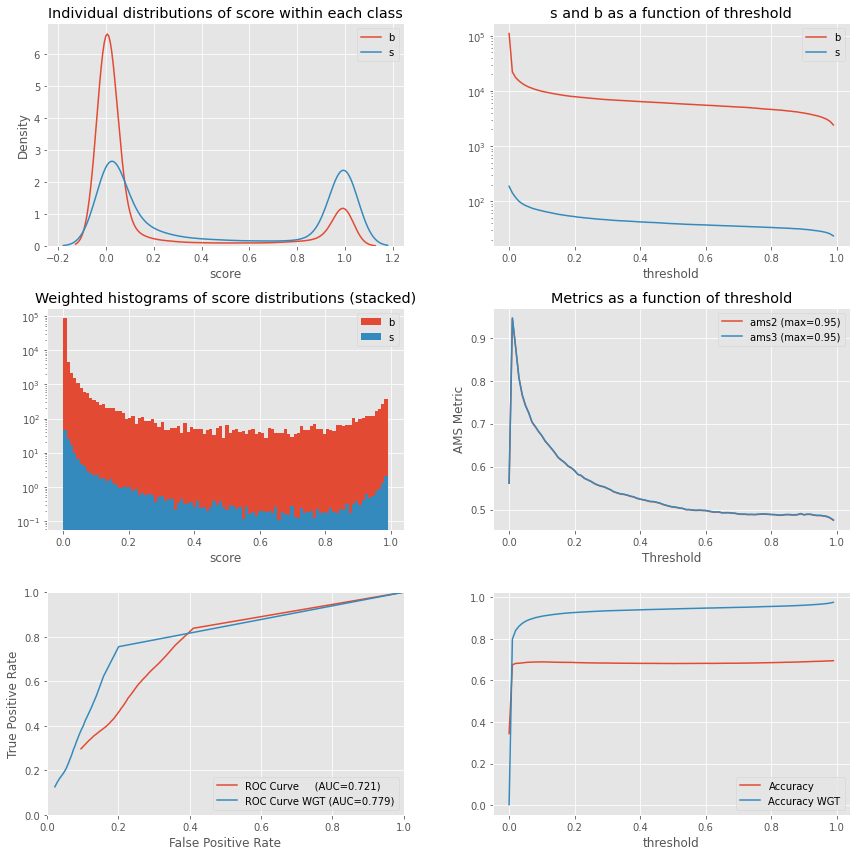

In [23]:
plot_results(nb_score_data, nb_score_summary)
#plt.savefig('outliers_mean.png')

Now we will run machine learning algorithms to fill missing data, and I will use Random Forest Regressor for that due to the fact that it is robust and not biased towards specific features. For that I will use data columns that have no missing values as training set and the ones with missing data as target data. Rows of training are the ones that don't have missing data and the ones to predict will be the ones with the missing values.

We should note that this method increases the correlation between columns but we can give it a shot and see the results of predictions.


In [25]:
df = pd.read_csv('training.csv').set_index('EventId')  # reloading the training set so that I process it all at once
print(df.columns, df.columns.shape)

Index(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object') (32,)


In [26]:
X = df
Y = df.loc[:,'Label']
X.shape, Y.shape

((250000, 32), (250000,))

In [27]:
#columns that have missing data
columns = ['DER_mass_MMC',                    
'DER_deltaeta_jet_jet',           
'DER_mass_jet_jet',               
'DER_prodeta_jet_jet',            
'DER_lep_eta_centrality',         
'PRI_jet_leading_pt',             
'PRI_jet_leading_eta',            
'PRI_jet_leading_phi',            
'PRI_jet_subleading_pt',          
'PRI_jet_subleading_eta',         
'PRI_jet_subleading_phi' ] 

In [28]:
X_train = X.drop(columns = columns)
X_train = X_train.drop(columns = ['Label','Weight'])
X_fill = X.loc[:,columns]

In [29]:
for i, val in enumerate(columns):
  X_train_train = X_train.loc[X_fill.loc[:,val] != -999]
  X_train_pred = X_train.loc[X_fill.loc[:,val] == -999]
  Y_train_pred = X_fill.loc[X_fill.loc[:,val] != -999].loc[:,val]
  clf = RandomForestRegressor(n_estimators=25)
  clf.fit(X_train_train,Y_train_pred)
  temp = clf.predict(X_train_pred)
  X.loc[X_fill.loc[:,val] == -999].loc[:,val] = temp
  print(i)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


1


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


2


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


3


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


4


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


5


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


6


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


7


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


8


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


9
10


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [30]:
#partitioning the training set again
training = X.iloc[0:175000,:]
evaluation = X.iloc[175000:182500,:]
holdout = X.iloc[182500:,:]
training.shape, evaluation.shape, holdout.shape

((175000, 32), (7500, 32), (67500, 32))

In [31]:
#creating an image of the label columns with floats again also
for df in training, evaluation, holdout:
    df.loc[:,'target'] = df.Label.map(lambda l: 1.0 if l=='s' else 0.0)
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [32]:
naive_bayes = GaussianNB()
naive_bayes.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(naive_bayes.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


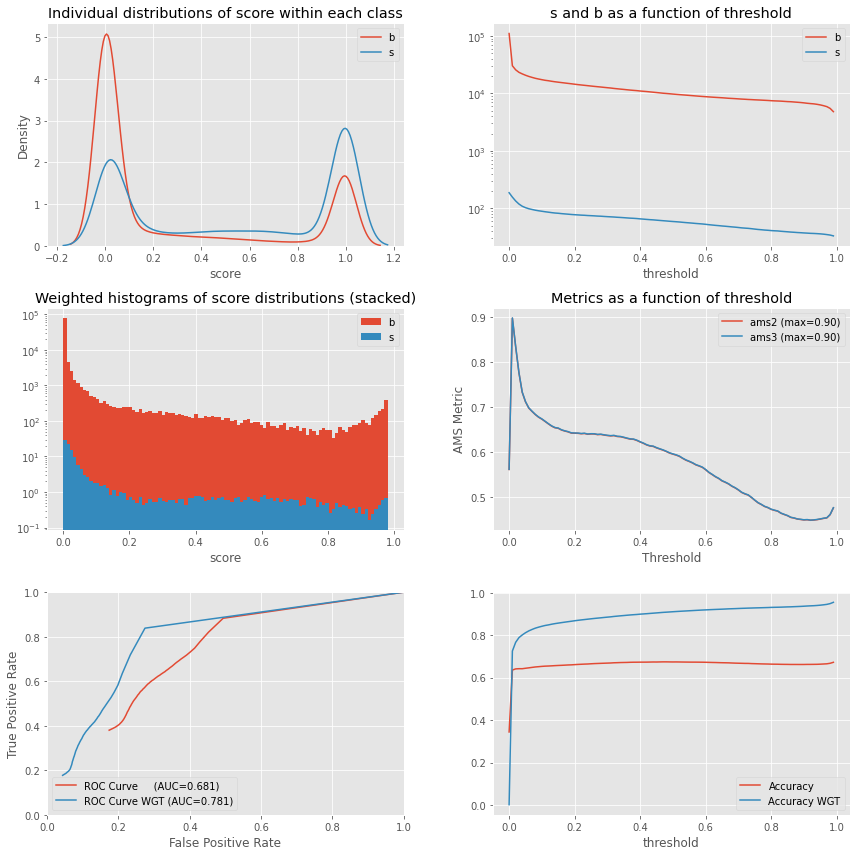

In [33]:
plot_results(nb_score_data, nb_score_summary)
#plt.savefig('RandomForest_outliers.png')

Now we will create artificial data that are based on physical experts, and then we will choose columns based on some analytics and after that evaluate. After that we will run pca and see if it can perform even better and reduce the dimension.

In [36]:
!python process_data.py       # this will create new datasets

Adding momentum features
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
Calculating jet_eta_plus
Calculating lep_tau_eta_plus
Calculating lep_z_momentum
Calculating jet_z_momentum
Calculating jet_lep_sum_z_momentum
Calculating jet_lep_diff_z_momentum
Calculating max_jet_pt
Calculating min_jet_pt
Calculating max_lep_pt
Calculating min_lep_pt
Calculating max_pt
Calculating min_pt
Calculatin

The code will devide the data into 3 files similar in size to the previois ones but with 83 columns

In [37]:
#reading the datasets
training = pd.read_csv('./training_processed.csv').set_index('EventId')
evaluation = pd.read_csv('./evaluation_processed.csv').set_index('EventId')
holdout = pd.read_csv('./holdout_processed.csv').set_index('EventId')

In [38]:
training.shape, evaluation.shape, holdout.shape

((175000, 86), (7500, 86), (13500, 86))

In [39]:
#add the target column that is a mapping of the Label column but in a numerical presentation:
for df in training, evaluation, holdout:
    df.loc[:,'target'] = df.Label.map(lambda l: 1.0 if l=='s' else 0.0)

In [40]:
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]   #eliminating columns that are not for features



Now we will see some charactaristics of the new dataset


In [41]:
info = []

for name, ds in [('training', training), ('evaluation', evaluation), ('holdout', holdout)]:
    i = OrderedDict()
    i['name'] = name
    i['size'] = len(ds)
    i['num_sig'] = len(ds[ds.Label=='s'])
    i['num_bkg'] = len(ds[ds.Label=='b'])
    i['frac'] = i['num_sig'] / (i['num_sig'] + i['num_bkg'])
    i['weight'] = ds.Weight.sum()
    i['weight_sig'] = ds[ds.Label=='s'].Weight.sum()
    i['weight_bkg'] = ds[ds.Label=='b'].Weight.sum()
    i['weight_frac_sig'] = i['weight_sig'] / (i['weight_sig'] + i['weight_bkg'])
    info.append(i)

ds_info = pd.DataFrame(info)
ds_info.T

0           1           2
name               training  evaluation     holdout
size                 175000        7500       13500
num_sig               59937        2467        4669
num_bkg              115063        5033        8831
frac               0.342497    0.328933    0.345852
weight               288510     12528.8     21980.4
weight_sig          484.082     19.2787     37.7361
weight_bkg           288026     12509.5     21942.7
weight_frac_sig  0.00167787  0.00153875  0.00171681

In [42]:
training.head().T

EventId                          247950   103304   192009   286112   253541
DER_mass_MMC                     79.946  131.933   85.178  110.089  138.925
DER_mass_transverse_met_lep      79.537    6.052   58.315    2.469   71.483
DER_mass_vis                     45.658   79.441    48.82   62.731   77.111
DER_pt_h                         158.21   22.587   29.316   49.877   98.503
DER_deltaeta_jet_jet              1.149     -999     -999    3.938     -999
...                                 ...      ...      ...      ...      ...
transverse_mass_jet_subleading  171.448  381.091  73.8384  8.21112  115.693
tau_fourenergy                  43.1806  45.4039  24.6806  35.2535  78.4405
lep_fourenergy                  86.3212  34.9398  30.7655  90.7894  112.235
lep_mass                         2079.8   6308.3  2381.74  3931.65   5945.2
target                                1        1        0        1        1

[87 rows x 5 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

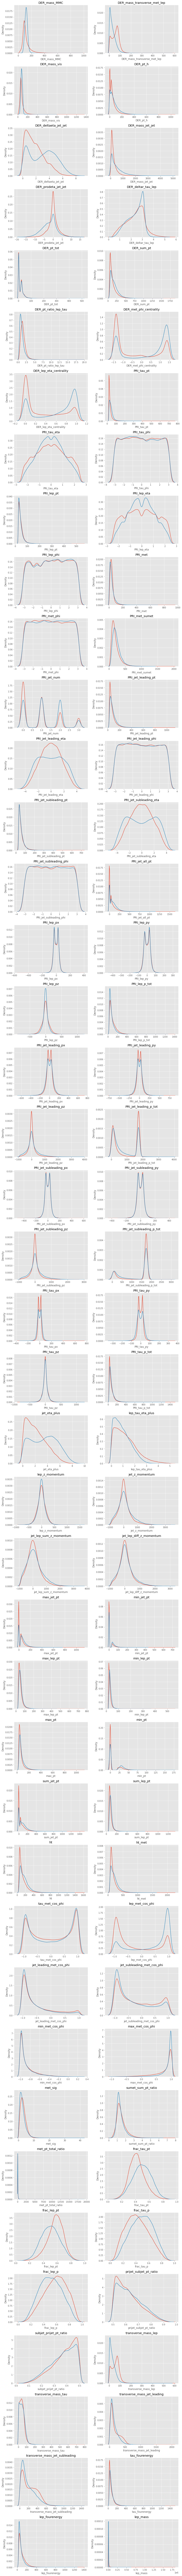

In [43]:
#Visualizing the Label class distribution per columns to detect which ones I will eliminate
num_features = len(feature_cols)
ncols, nrows = 2, math.ceil(num_features / 2)

fig = plt.figure(figsize=(12, 4*nrows))

labels = training.Label.unique()

for i, f in enumerate(feature_cols):
    
    plt.subplot(nrows, ncols, i+1)
                  
    for label in ['b', 's']:
        sns.distplot(training[(training.Label==label) & (training[f] > -900)][f].dropna(), label=label, ax=plt.gca(),
                     hist=False, rug=False)            
    plt.title(f)
        
plt.tight_layout()

Outliers will be kept as -999 and not touched and then choose from above the best configuration to manage outliers and run it with this methd and see the results.

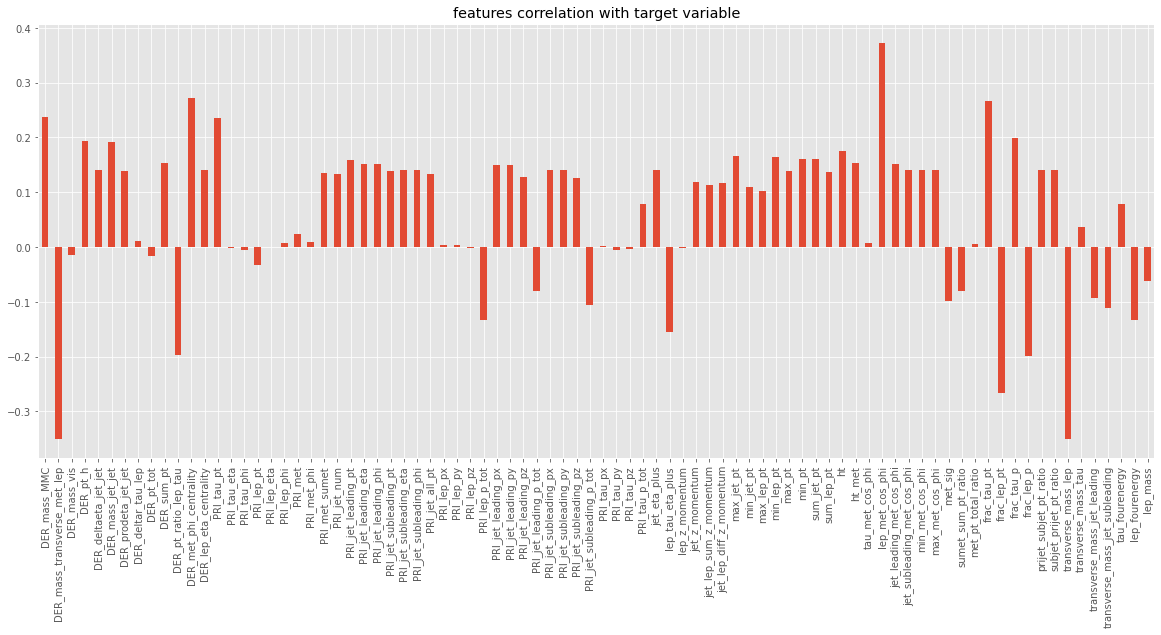

In [44]:
training.drop(columns=['target','Weight']).corrwith(training.loc[:,'target']).plot(kind='bar', figsize=(20, 8), title='features correlation with target variable',grid = True)

In [45]:
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(training.corr(), annot=True, linewidths=.5, ax=ax)

Output hidden; open in https://colab.research.google.com to view.

In [46]:
# We hand select a number of features that appear to show
# good discrimination

selected_features = [
    'DER_mass_MMC',
    'DER_mass_transverse_met_lep',
    'DER_mass_vis',
    'DER_pt_h',
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_deltar_tau_lep',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'DER_met_phi_centrality',
    'DER_lep_eta_centrality',
    'PRI_tau_pt',
    'PRI_tau_eta',
    'PRI_lep_eta',
    'PRI_jet_num',
    'PRI_jet_leading_eta',
    'PRI_jet_subleading_eta',
    'PRI_jet_all_pt',
    'jet_eta_plus',
    'lep_tau_eta_plus',
    'min_pt',
    'lep_met_cos_phi',
    'jet_subleading_met_cos_phi',
    'max_met_cos_phi',
    'frac_tau_pt'
]

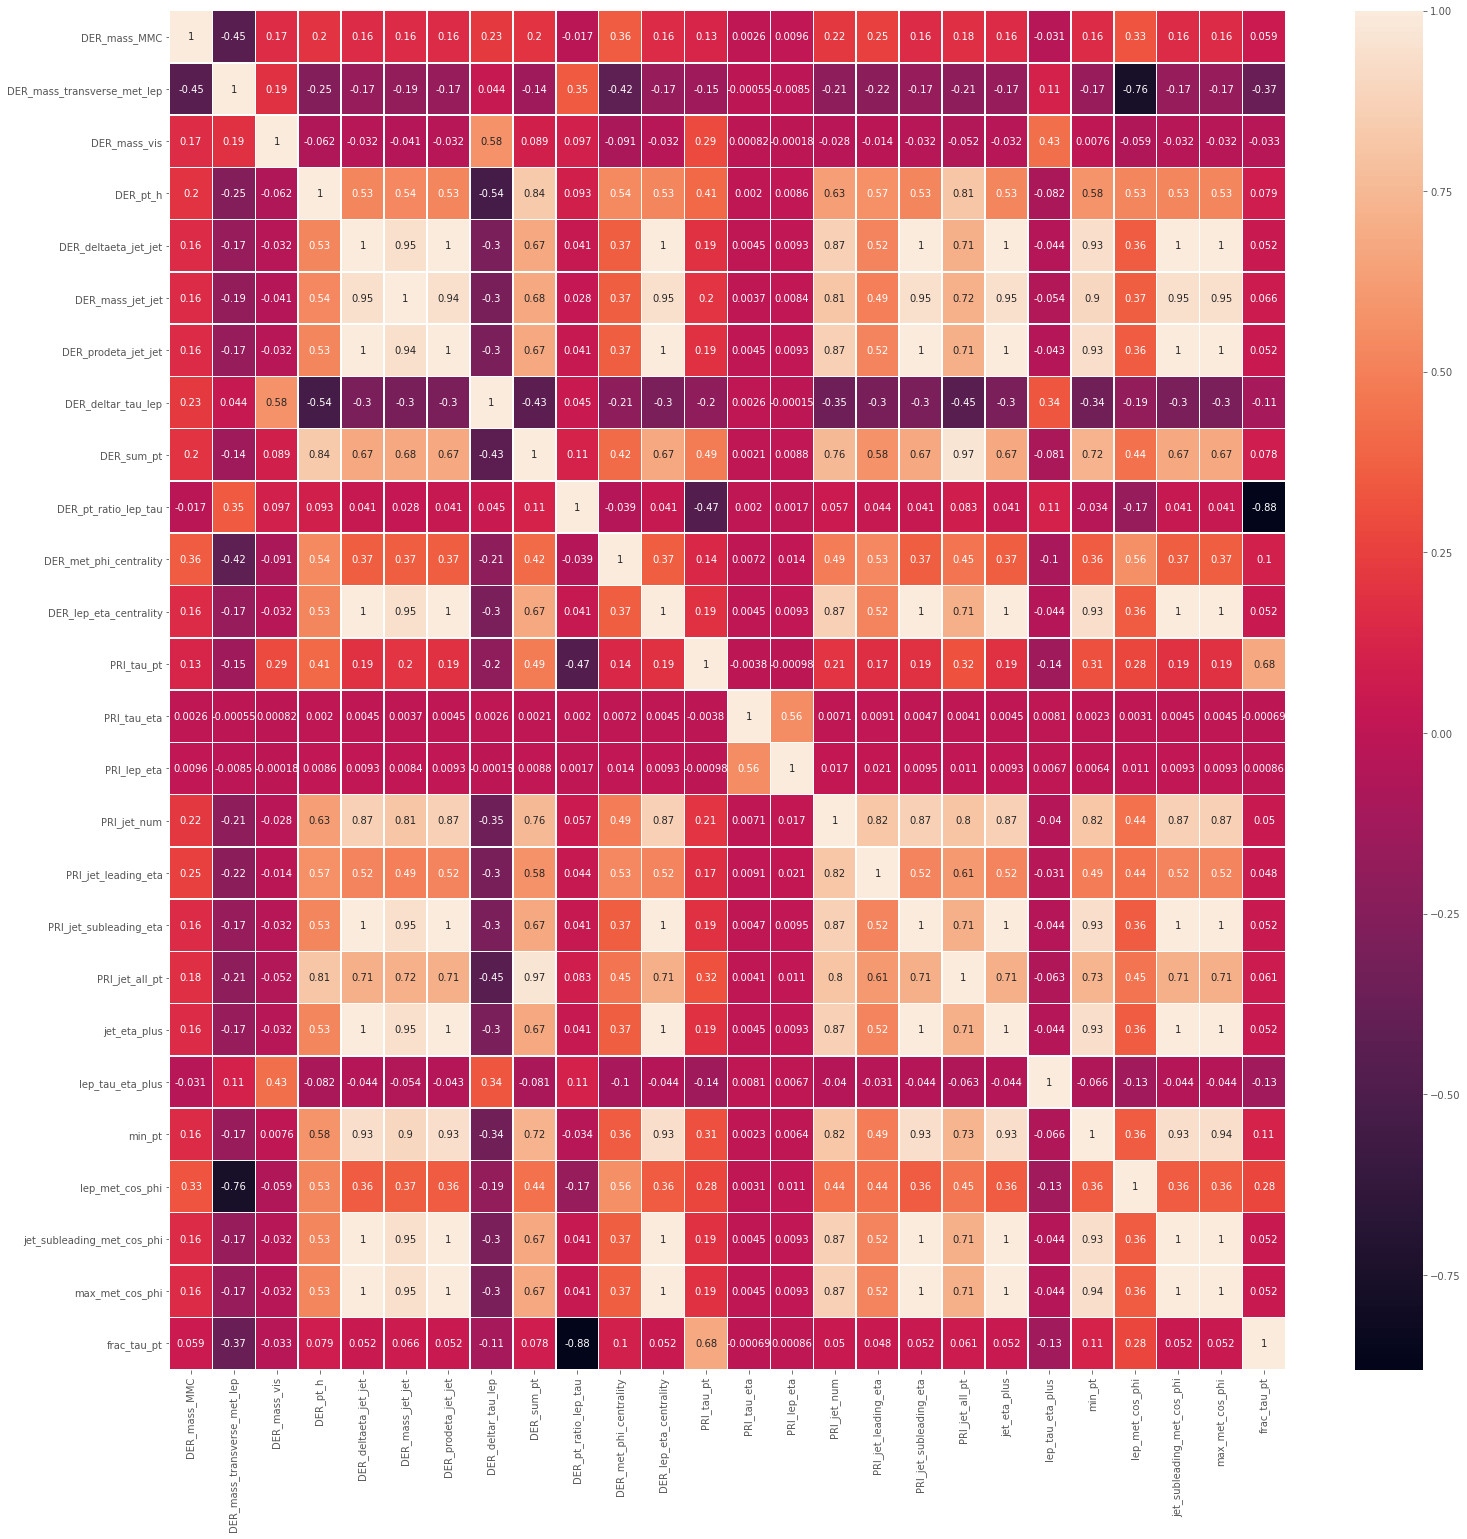

In [47]:
fig, ax = plt.subplots(figsize=(25,25)) 
sns.heatmap(training[selected_features].corr(), annot=True, linewidths=.5, ax=ax)

In [48]:
(training[selected_features] == -999).sum()

DER_mass_MMC                    26675
DER_mass_transverse_met_lep         0
DER_mass_vis                        0
DER_pt_h                            0
DER_deltaeta_jet_jet           124353
DER_mass_jet_jet               124353
DER_prodeta_jet_jet            124353
DER_deltar_tau_lep                  0
DER_sum_pt                          0
DER_pt_ratio_lep_tau                0
DER_met_phi_centrality              0
DER_lep_eta_centrality         124353
PRI_tau_pt                          0
PRI_tau_eta                         0
PRI_lep_eta                         0
PRI_jet_num                         0
PRI_jet_leading_eta             70097
PRI_jet_subleading_eta         124353
PRI_jet_all_pt                      0
jet_eta_plus                   124353
lep_tau_eta_plus                    0
min_pt                              0
lep_met_cos_phi                     0
jet_subleading_met_cos_phi     124353
max_met_cos_phi                124353
frac_tau_pt                         0
dtype: int64

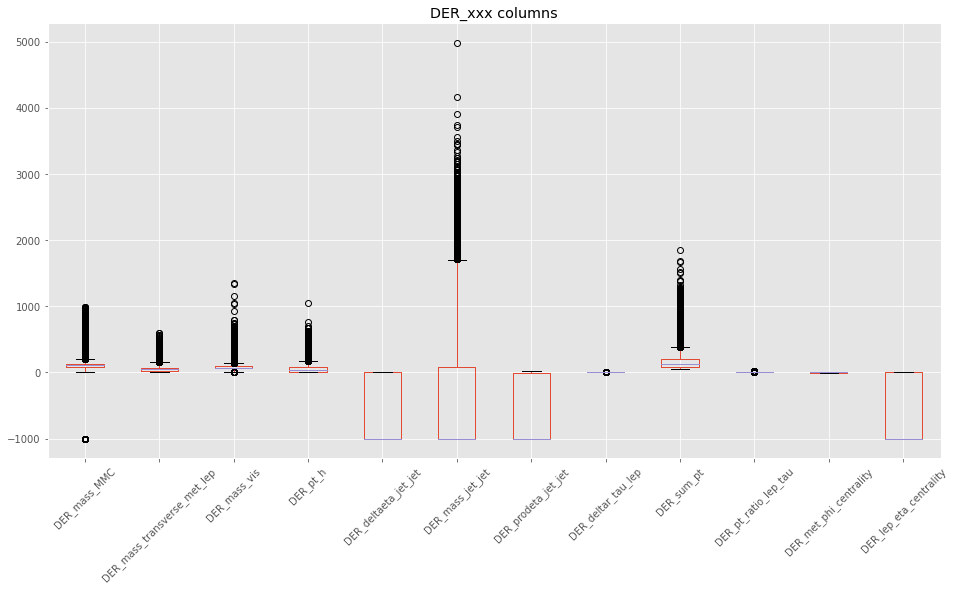

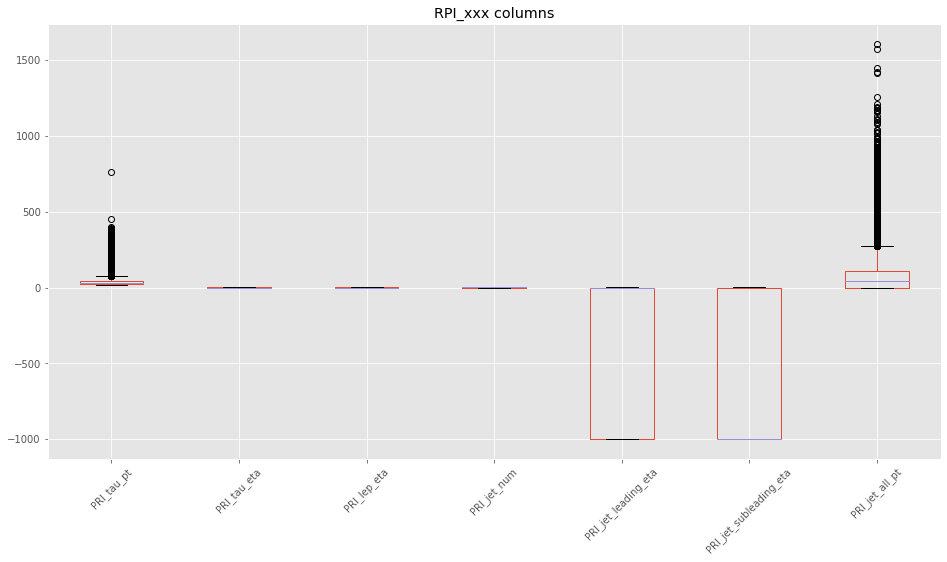

In [49]:
cols_der = [col for col in training[selected_features].columns if col.startswith('DER')]
cols_pri = [col for col in training[selected_features].columns if col.startswith('PRI')]

#print(len(cols_der), len(cols_pri))

# plot only DER columns
training[selected_features][cols_der].plot(kind='box', figsize=(16, 8))
plt.xticks(rotation=45);
plt.title('DER_xxx columns')
plt.show()

# plot only PRI columns
training[selected_features][cols_pri].plot(kind='box', figsize=(16, 8))
plt.xticks(rotation=45);
plt.title('RPI_xxx columns')
plt.show()

In [50]:
print(training.loc[:,'DER_deltaeta_jet_jet'].mean(), training.loc[:,'DER_deltaeta_jet_jet'].std())
print(training.loc[:,'DER_mass_jet_jet'].mean(), training.loc[:,'DER_mass_jet_jet'].std())        
print(training.loc[:,'DER_prodeta_jet_jet'].mean(), training.loc[:,'DER_prodeta_jet_jet'].std())

-709.1817449257094 454.12893668087963
-602.1118783371413 657.454782706647
-710.1173893485707 452.6659983631521


In [51]:
for i in ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality','PRI_jet_leading_eta', 'PRI_jet_subleading_eta', 'jet_eta_plus', 'jet_subleading_met_cos_phi', 'max_met_cos_phi'                ]:
  temp = training.loc[training.loc[:,i]!=-999,i]
  print(f'{i}: mean is {temp.mean()} and std is {temp.std()}')

DER_deltaeta_jet_jet: mean is 2.4057029636503673 and std is 1.7439384996976024
DER_mass_jet_jet: mean is 372.3629887456302 and std is 396.45075140879
DER_prodeta_jet_jet: mean is -0.8272185124489206 and std is 3.594343082014295
DER_lep_eta_centrality: mean is 0.45837226291783983 and std is 0.39875238520051487
PRI_jet_leading_eta: mean is -0.006178145524913456 and std is 1.7835193964734979
PRI_jet_subleading_eta: mean is -0.015372302406855356 and std is 2.0319182234971906
jet_eta_plus: mean is 2.782282274696466 and std is 1.9219282211657203
jet_subleading_met_cos_phi: mean is -0.23505847374479358 and std is 0.6731035691108698
max_met_cos_phi: mean is 0.8130275679534252 and std is 0.2955213957145


In [52]:
naive_bayes = GaussianNB()
naive_bayes.fit(training[selected_features], training.target)
nb_predictions = pd.Series(naive_bayes.predict_proba(holdout[selected_features])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


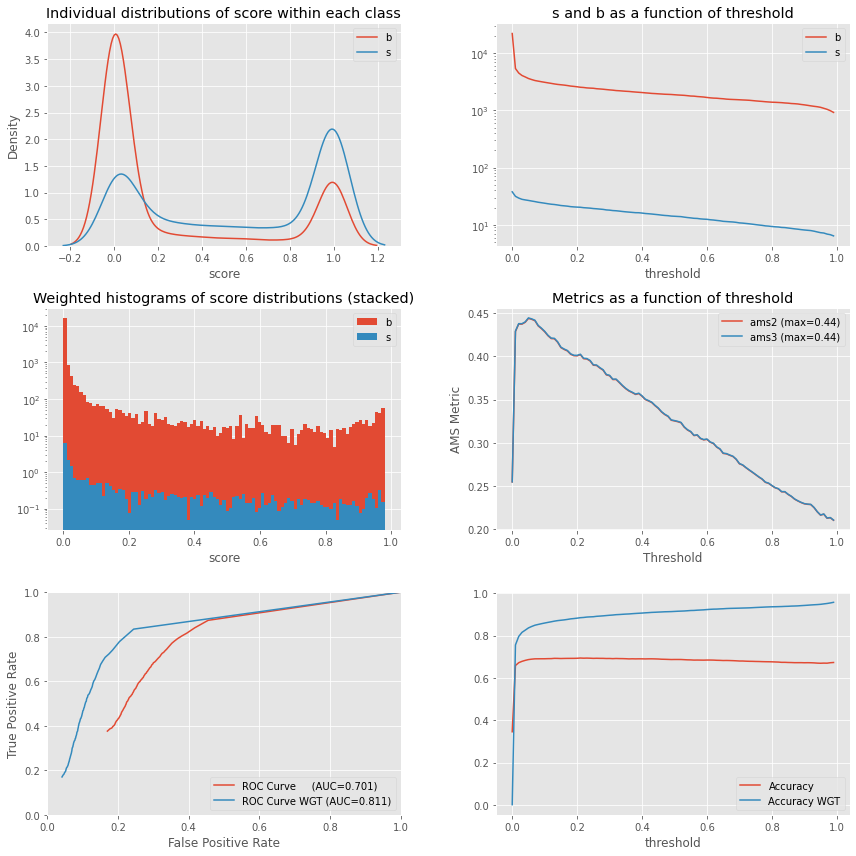

In [53]:
plot_results(nb_score_data, nb_score_summary)



We can see that using the generated data the results got much better. But the selection of features after was done in a naive way so I have to try something more efficient and for that I will run PCA and see the results after that I will also consider the fact that the filling of outliers by the mean of each column had also better results so after PCA I will also try to fit it to the best configuration and see the final result. After that I will take the very best configuration and run more efficient algorithms to see the best one of all.


In [54]:
#Reloading the data
training = pd.read_csv('./training_processed.csv').set_index('EventId')
evaluation = pd.read_csv('./evaluation_processed.csv').set_index('EventId')
holdout = pd.read_csv('./holdout_processed.csv').set_index('EventId')
for df in training, evaluation, holdout:
    df.loc[:,'target'] = df.Label.map(lambda l: 1.0 if l=='s' else 0.0)

In [55]:
training.shape, evaluation.shape, holdout.shape 

((175000, 87), (7500, 87), (13500, 87))

In [56]:
#concatinate the 3 datasets to process them all at once
df = pd.concat([training,evaluation],axis=0)
df = pd.concat([df,holdout],axis=0)

In [57]:
df.shape     #checking if concatination was done successfully

(196000, 87)

In [58]:
(df.isna().sum()!=0).any()

False

In [59]:
df.columns

Index(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz',
       'PRI_lep_p_tot', 'PRI_jet_leading_px', 'PRI_jet_leading_py',
       'PRI_jet_leading_pz', 'PRI_jet_leading_p_tot', 'PRI_jet_subleading_px',
       'PRI_jet_subleading_py', 'PRI_jet_subleading_pz',
       'PRI_jet_subleading_p_tot', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz',
       'PRI

Now I will see the best PCA configuration the only hyper-parameter that I will tune is the number of principle components.

In [61]:
pca_higgs = PCA(n_components=35)
principalComponents_df = pca_higgs.fit_transform(df.drop(columns=['target','Label','Weight']))

In [62]:
principalComponents_df.shape     #checking if the PCA ran correctly

(196000, 35)

In [63]:
#transforming into a dataset because PCA gives a numpy array and resetting the index
principalComponents_df = pd.DataFrame(principalComponents_df,index=range(0,196000,1))  



Now I will add the other columns that I need to train and visualize


In [64]:
df_temp = pd.DataFrame(df.loc[:,['target','Label','Weight']]).reset_index().drop(columns=['EventId'])
df_temp

target Label    Weight
0          1.0     s  0.002653
1          1.0     s  0.001503
2          0.0     b  1.681611
3          1.0     s  0.001503
4          1.0     s  0.001503
...        ...   ...       ...
195995     1.0     s  0.001502
195996     0.0     b  2.147377
195997     1.0     s  0.018636
195998     0.0     b  2.711200
195999     0.0     b  0.744056

[196000 rows x 3 columns]

In [65]:
principalComponents_df = pd.concat([principalComponents_df,df_temp],axis = 1)

In [66]:
# Now repartition the dataset into three parts
training = principalComponents_df.iloc[0:175000,:]
evaluation = principalComponents_df.iloc[175000:182500,:]
holdout = principalComponents_df.iloc[182500:,:]
training.shape, evaluation.shape, holdout.shape

((175000, 38), (7500, 38), (13500, 38))

In [67]:
training.isna().sum().any(), evaluation.isna().sum().any(), holdout.isna().sum().any()    #checking if errors occured

(False, False, False)

In [68]:
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]   #eliminating columns that are not for features

In [69]:
naive_bayes = GaussianNB()
naive_bayes.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(naive_bayes.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

In [70]:
plot_results(nb_score_data, nb_score_summary)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


Ok 35 principle components gave decent results and are an acceptable number of columsn to train on efficiently. Now I will repeat the training in the following steps:

*   Normalize data
*   First I will replace outliers with the mean which became 0
*   Then I run PCA with 35 principle components
*   Then I try Running Naive Baise, Random Forest Regressor, Logistic Regression, and SVMs



In [71]:
training = pd.read_csv('./training_processed.csv').set_index('EventId')
evaluation = pd.read_csv('./evaluation_processed.csv').set_index('EventId')
holdout = pd.read_csv('./holdout_processed.csv').set_index('EventId')
for df in training, evaluation, holdout:
    df.loc[:,'target'] = df.Label.map(lambda l: 1.0 if l=='s' else 0.0)

In [72]:
training.shape, evaluation.shape, holdout.shape #loading the processed data again

((175000, 87), (7500, 87), (13500, 87))

In [73]:
#Filling data with the mean
for i in ['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_leading_pt', 
          'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',]:
  temp = training[training.loc[:,i]!=-999].loc[:,i]
  mean = temp.mean()
  training.loc[(training.loc[:,i]==-999), i] = mean
  evaluation.loc[(evaluation.loc[:,i]==-999), i] = mean
  holdout.loc[(holdout.loc[:,i]==-999), i] = mean
training.head()

DER_mass_MMC  DER_mass_transverse_met_lep  ...     lep_mass  target
EventId                                             ...                     
247950         79.946                       79.537  ...  2079.799265     1.0
103304        131.933                        6.052  ...  6308.301056     1.0
192009         85.178                       58.315  ...  2381.738240     0.0
286112        110.089                        2.469  ...  3931.647261     1.0
253541        138.925                       71.483  ...  5945.195302     1.0

[5 rows x 87 columns]

In [74]:
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]

In [76]:
# Normalizing data
scaler = preprocessing.StandardScaler().fit(training[feature_cols])
training[feature_cols] = scaler.transform(training[feature_cols])
evaluation[feature_cols] = scaler.transform(evaluation[feature_cols])
holdout[feature_cols] = scaler.transform(holdout[feature_cols])

In [77]:
#concatinate the 3 datasets to process them all at once
df = pd.concat([training,evaluation],axis=0)
df = pd.concat([df,holdout],axis=0)

In [78]:
pca_higgs = PCA(n_components=35)
principalComponents_df = pca_higgs.fit_transform(df.drop(columns=['target','Label','Weight']))

In [80]:
#transforming into a dataset because PCA gives a numpy array and resetting the index
principalComponents_df = pd.DataFrame(principalComponents_df,index=range(0,196000,1))  

In [81]:
principalComponents_df = pd.concat([principalComponents_df,df_temp],axis = 1)

In [82]:
training = principalComponents_df.iloc[0:175000,:]
evaluation = principalComponents_df.iloc[175000:182500,:]
holdout = principalComponents_df.iloc[182500:,:]
training.shape, evaluation.shape, holdout.shape

((175000, 38), (7500, 38), (13500, 38))

In [83]:
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]   #eliminating columns that are not for features

**Naive Bayes**

In [84]:
naive_bayes = GaussianNB()
naive_bayes.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(naive_bayes.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


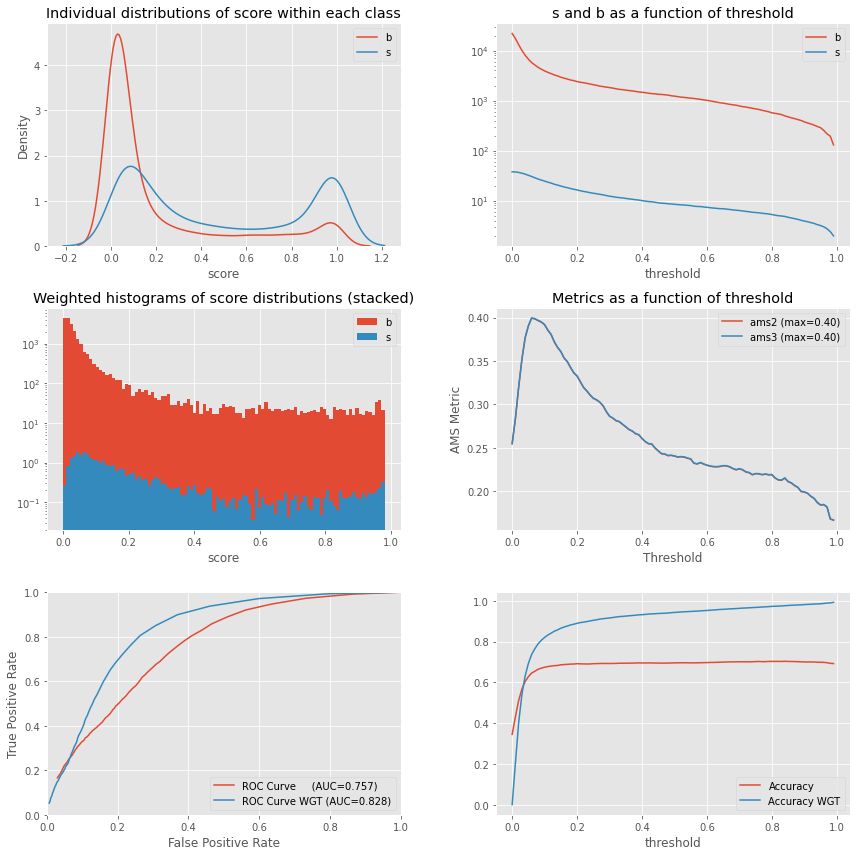

In [85]:
plot_results(nb_score_data, nb_score_summary)

**Logistic Regression**



Now I will run the logistic regression because it doesn't need any hyper-parameter tuning. Although I said before that it is not efficient to use it as discriminator but still I will try to see how accurately it will work on the data.


In [88]:
logisticRegr = LogisticRegression()
logisticRegr.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(logisticRegr.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


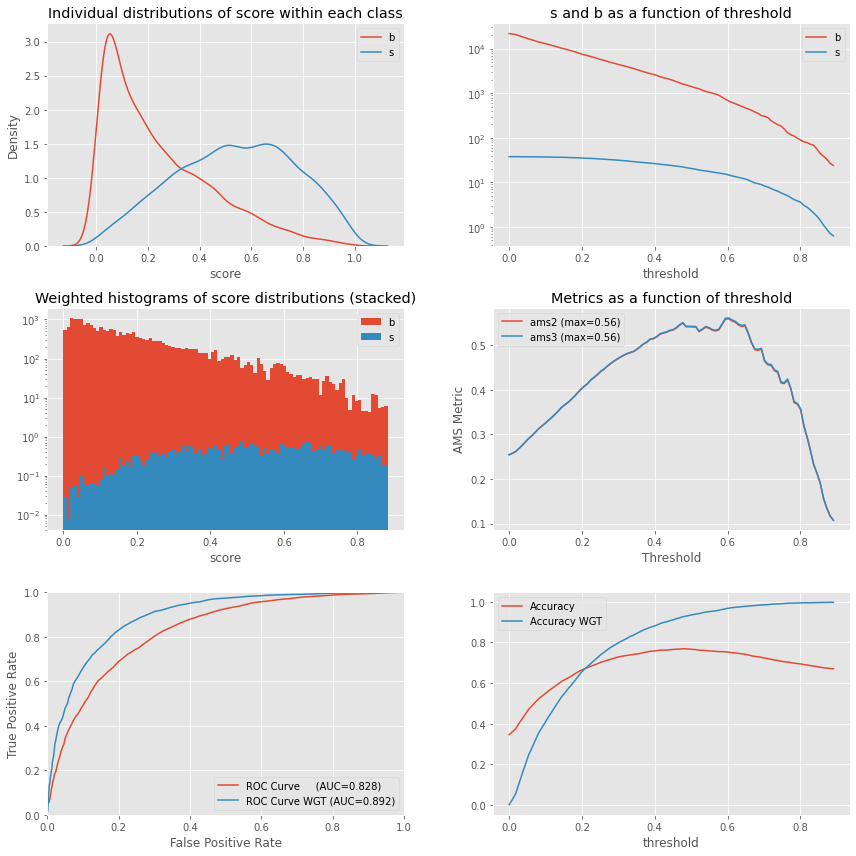

In [89]:
plot_results(nb_score_data, nb_score_summary)

In terms of ROC it worked much better but in alla other curves we can see a lot of fluctuations. asm2, and asm3 are higher for their maximum value but seem to reach a good point at last. But the distribution of signals and background are not discriminatively distributed. Accuracy is better in general. So in general this model performs better

**Random Forest Classifier**

In [91]:
clf = RandomForestClassifier(n_estimators=50)
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


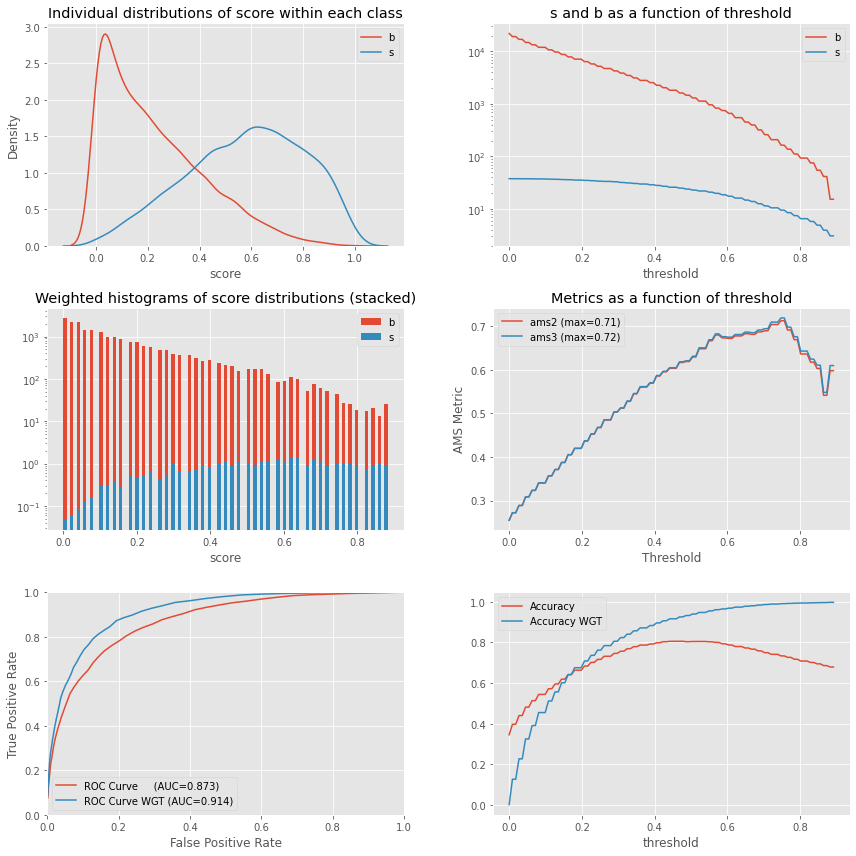

In [92]:
plot_results(nb_score_data, nb_score_summary)



For SVM hyper-parameter tuning I can't test in the regular way over the whole dataset. So I will be decreasing the dataset size for both dimention. First I will run SVM again but leave 18 columns and take feyewer rows from each set and test on them and the best configuration will be taken into account and trained on from the start.


In [95]:
training = pd.read_csv('./training_processed.csv').set_index('EventId')
evaluation = pd.read_csv('./evaluation_processed.csv').set_index('EventId')
holdout = pd.read_csv('./holdout_processed.csv').set_index('EventId')
for df in training, evaluation, holdout:
  df.loc[:,'target'] = df.Label.map(lambda l: 1.0 if l=='s' else 0.0)
for i in ['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_leading_pt', 
          'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',]:
  temp = training[training.loc[:,i]!=-999].loc[:,i]
  mean = temp.mean()
  training.loc[(training.loc[:,i]==-999), i] = mean
  evaluation.loc[(evaluation.loc[:,i]==-999), i] = mean
  holdout.loc[(holdout.loc[:,i]==-999), i] = mean
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]
scaler = preprocessing.StandardScaler().fit(training[feature_cols])
training[feature_cols] = scaler.transform(training[feature_cols])
evaluation[feature_cols] = scaler.transform(evaluation[feature_cols])
holdout[feature_cols] = scaler.transform(holdout[feature_cols])
#concatinate the 3 datasets to process them all at once
df = pd.concat([training,evaluation],axis=0)
df = pd.concat([df,holdout],axis=0)

In [96]:
df_temp = pd.DataFrame(df.loc[:,['target','Label','Weight']]).reset_index().drop(columns=['EventId'])
df_temp

target Label    Weight
0          1.0     s  0.002653
1          1.0     s  0.001503
2          0.0     b  1.681611
3          1.0     s  0.001503
4          1.0     s  0.001503
...        ...   ...       ...
195995     1.0     s  0.001502
195996     0.0     b  2.147377
195997     1.0     s  0.018636
195998     0.0     b  2.711200
195999     0.0     b  0.744056

[196000 rows x 3 columns]

Now that the data is prepared I will start the search I will follow 2 ways:


*   List iteThe first I will run manually some confifurations to judge based on many metrics 
*   Then I will run a grid search to find the best configuration automatically, but this one will not take all metrics I implemented into account



In [97]:
pca_higgs = PCA(n_components=18)
principalComponents_df = pca_higgs.fit_transform(df.drop(columns=['target','Label','Weight']))
principalComponents_df = pd.DataFrame(principalComponents_df,index=range(0,196000,1))
principalComponents_df = pd.concat([principalComponents_df,df_temp],axis = 1)

In [98]:
training = principalComponents_df.iloc[0:17500,:]
evaluation = principalComponents_df.iloc[17500:18250,:]
holdout = principalComponents_df.iloc[18250:20000,:]
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]   #eliminating columns that are not for features

I will start by the simplest hyper parameter thatis C and find the best value for 3 different kernel functions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(101,) <class 'pandas.core.series.Series'>


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


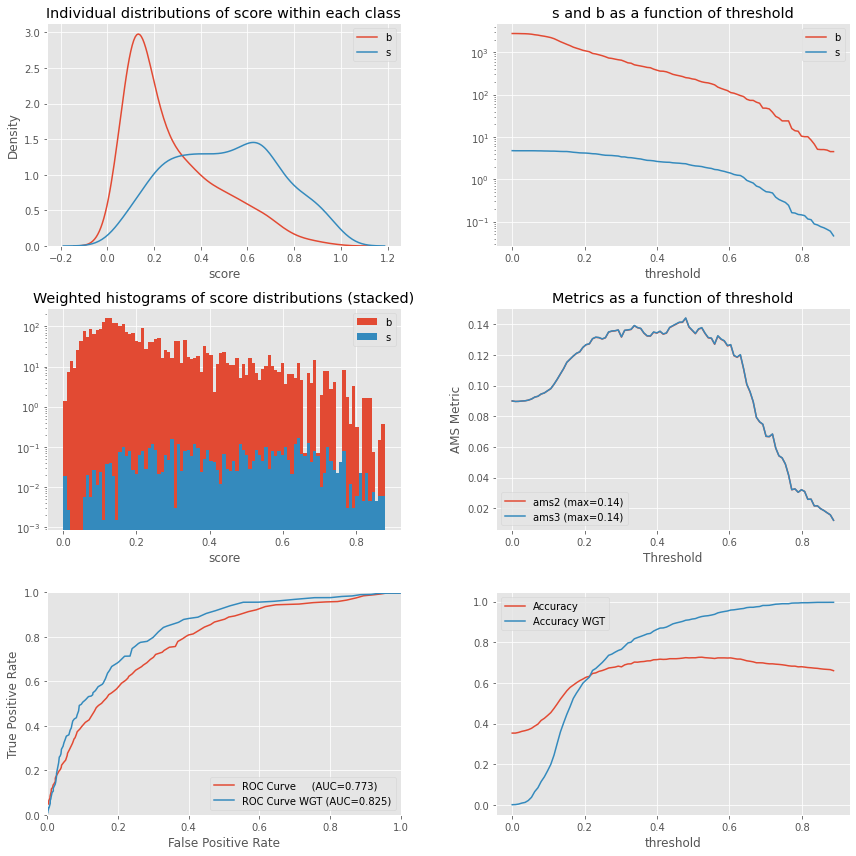

In [100]:
clf = svm.SVC(kernel='linear',C=0.001,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [101]:
clf = svm.SVC(kernel='linear',C=0.01,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)

In [102]:
plot_results(nb_score_data, nb_score_summary)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [103]:
clf = svm.SVC(kernel='linear',C=0.1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(100,) <class 'pandas.core.series.Series'>


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(101,) <class 'pandas.core.series.Series'>


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


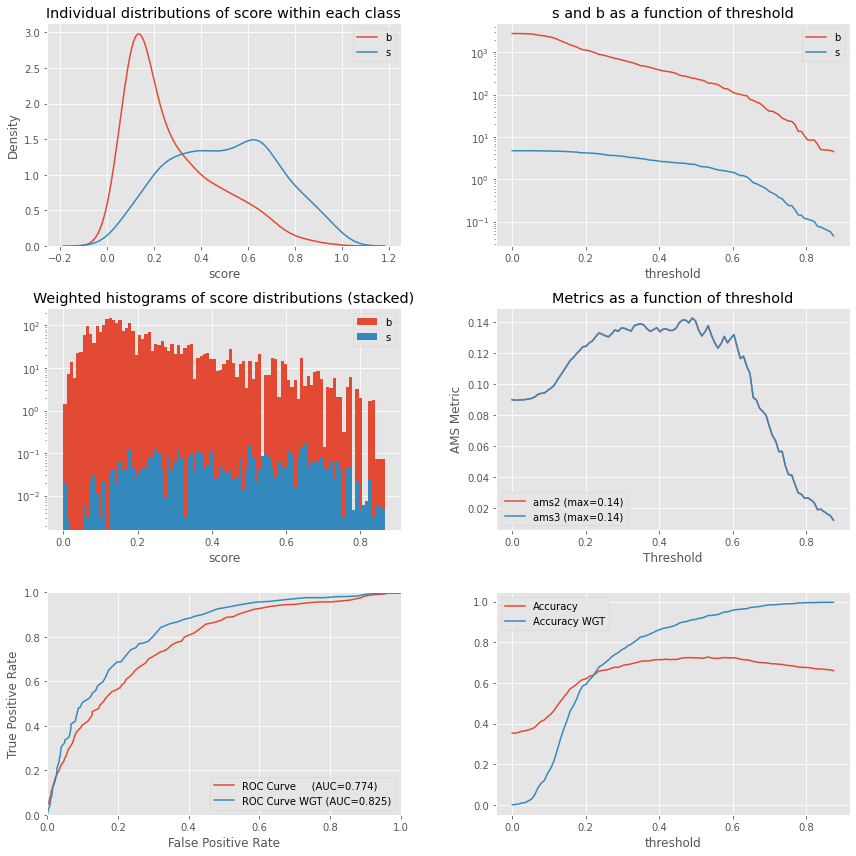

In [104]:
clf = svm.SVC(kernel='linear',C=1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='linear',C=10,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)



It was quite obvious that the value of C did not affect the performance of the SVM under the linear kernel. So, I will take the default value of C and might decrease it in case the code took longer than it should to run




Now I will see the best value of C under the rbf kernel


In [ ]:
clf = svm.SVC(kernel='rbf',probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='rbf',C = 0.001,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='rbf',C=0.01,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='rbf',C=0.1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='rbf',C=10,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)



For rbf kernel we got different results and depending on the judging metric the best value will be chosen, not to forget to mention that also the target value also has it's impact on the choice.


In [ ]:
clf = svm.SVC(kernel='sigmoid',probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='sigmoid',C=0.001,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='sigmoid',C=0.01,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='sigmoid',C=0.1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='sigmoid',C=10,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

For sigmoid the case is the same as rbf



Now I will make a search over gamma and fix C to the default value, for those who need a specific metric to work on they can just go with the best configuration above and retune gamma according to it


In [ ]:
clf = svm.SVC(kernel='linear',gamma=0.001,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='linear',gamma=0.01,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='linear',gamma=0.1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='linear',gamma=1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

The linear kernel is not affected by the value of gamma. This makes the linear kernel robust to both gamma and C

In [ ]:
clf = svm.SVC(kernel='rbf',gamma=0.001,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='rbf',gamma=0.01,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='rbf',gamma=0.1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='rbf',gamma=1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

For the rbf kernel gamma had a great impact on varying the metrics of both ROC curve and AMS depending on the application we can choose gamma

sigmoid:

In [ ]:
clf = svm.SVC(kernel='sigmoid',gamma=0.001,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='sigmoid',gamma=0.01,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='sigmoid',gamma=0.1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [ ]:
clf = svm.SVC(kernel='sigmoid',gamma=1,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)



Sigmoid was not a stable function and messed up the ROC curve but for the AMS it achived best results with many fluctuation so even the selection of the threshold will need much more tuning still to balance between it and acurracy




Now I will run an automatical grid search to find the best hyper parameter tuning and from previous we can see that each kernel has achieved some desires that's why I will see what best parameters work with each kernel


In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
svc_param_selection(training[feature_cols],training.target,5)

In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
svc_param_selection(training[feature_cols],training.target,5)

In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='sigmoid'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
svc_param_selection(training[feature_cols],training.target,5)



For the final run I will stick with the linear kernel since it is the most robust one and fastest and keep the horizon open for others to try and maybe better tune other configurations. I will also go with the grid search results where C = 0.01 and gamma = 0.001


First I will reload the data from the beginning and run the algorithm. So far it is hown that SVM is the best algorithm to cut any suspicion I will run now SVM over the whole data

In [ ]:
# data loading
training = pd.read_csv('./training_processed.csv').set_index('EventId')
evaluation = pd.read_csv('./evaluation_processed.csv').set_index('EventId')
holdout = pd.read_csv('./holdout_processed.csv').set_index('EventId')
for df in training, evaluation, holdout:
  df.loc[:,'target'] = df.Label.map(lambda l: 1.0 if l=='s' else 0.0)
for i in ['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_leading_pt', 
          'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',]:
  temp = training[training.loc[:,i]!=-999].loc[:,i]
  mean = temp.mean()
  training.loc[(training.loc[:,i]==-999), i] = mean
  evaluation.loc[(evaluation.loc[:,i]==-999), i] = mean
  holdout.loc[(holdout.loc[:,i]==-999), i] = mean
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(training[feature_cols])
training[feature_cols] = scaler.transform(training[feature_cols])
evaluation[feature_cols] = scaler.transform(evaluation[feature_cols])
holdout[feature_cols] = scaler.transform(holdout[feature_cols])
#concatinate the 3 datasets to process them all at once
df = pd.concat([training,evaluation],axis=0)
df = pd.concat([df,holdout],axis=0)

In [ ]:
df_temp = pd.DataFrame(df.loc[:,['target','Label','Weight']]).reset_index().drop(columns=['EventId'])
df_temp

In [ ]:
pca_higgs = PCA(n_components=25)
principalComponents_df = pca_higgs.fit_transform(df.drop(columns=['target','Label','Weight']))
principalComponents_df = pd.DataFrame(principalComponents_df,index=range(0,196000,1))
principalComponents_df = pd.concat([principalComponents_df,df_temp],axis = 1)

In [ ]:
training = principalComponents_df.iloc[0:175000,:]
evaluation = principalComponents_df.iloc[175000:182500,:]
holdout = principalComponents_df.iloc[182500:,:]
training.shape, evaluation.shape, holdout.shape

In [ ]:
feature_cols = [col for col in training if col not in {'Weight', 'Label', 'target'}]

In [ ]:
clf = svm.SVC(kernel='linear',gamma=0.001,C=0.01,probability=True) 
clf.fit(training[feature_cols], training.target)
nb_predictions = pd.Series(clf.predict_proba(holdout[feature_cols])[:, 1], index=holdout.index)
nb_score_data, nb_score_summary = create_result_df(nb_predictions, holdout.Label, holdout.Weight)
plot_results(nb_score_data, nb_score_summary)

In [1]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler


# x_train = normalize(x_train)
# x_test = normalize(x_test)

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_train.columns)

NameError: ignored

In [ ]:
clf = svm.SVC(kernel='rbf',gamma=0.01,C=10) 
clf.fit(training[feature_cols], training.target)
predictions = clf.predict(evaluation[feature_cols])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(confusion_matrix(evaluation.target, predictions))
plot_confusion_matrix(clf, evaluation[feature_cols], evaluation.target)
plt.savefig('confusion matrix.png')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_2d_tr = tsne.fit_transform(X_train.values)

In [ ]:
pd.DataFrame(tsne_2d_tr).to_csv('tsne_embeddings.csv')
plot_scatter(tsne_2d_tr, y_train)

In [ ]:
tsne = TSNE(n_components=2)
tsne_2d_tr = tsne.fit_transform(X_train.values)
tsne_2d_te = tsne.fit_transform(X_test.values)

In [ ]:
tsne = TSNE(n_components=2)
tsne_2d_te = tsne.fit_transform(X_test.values)

In [ ]:
pd.DataFrame(tsne_2d_te).to_csv('tsne_embeddings_test.csv')

In [ ]:
plot_scatter(tsne_2d_tr, y_train)